In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import seaborn as sns
from datetime import datetime

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.plotting.backend = "plotly"

pd.set_option("display.max_columns", None) # Display all the columns of the dataframes

C:\Users\alexb\AppData\Local\Temp\ipykernel_19152\3102968465.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
# Original dataset without data engineering applied in the regression approach
data  = pd.read_pickle('./TO_FE_20211221.pkl')
data = data['2021-11-08 00:00:00':] # Discard the first part of the dataset that contains too many outliers

# Dataset split
train_set = data[:round(len(data)*0.8)]
test_set = data[round(len(data)*0.8):]

In [3]:
data['MG_NIR_Salida_Ext'].plot()

In [27]:
# For the first analysis I use only the target variable.
y = pd.DataFrame(train_set['MG_NIR_Salida_Ext'], columns = ['MG_NIR_Salida_Ext'])

# EXPLORATORY DATA ANALYSIS

In [5]:
y.describe()

,MG_NIR_Salida_Ext
count,3265.000000
mean,0.583218
std,0.097751
min,0.274940
25%,0.516986
50%,0.587909
75%,0.652982
max,0.924142


In [6]:
# Installing holoviews to use as pandas backend

# !pip install holoviews
# pip install typing-extensions --upgrade
# !pip install hvplot
# import pkg_resources
# pkg_resources.require("panel==0.13.0")  # modified to use specific numpy
# import panel


In [7]:
y.plot(kind='box')
# y.plot(kind='box', colormap='winter', backend = 'holoviews')

In [8]:
y.plot(kind='hist', bins=40)

<AxesSubplot:ylabel='Density'>

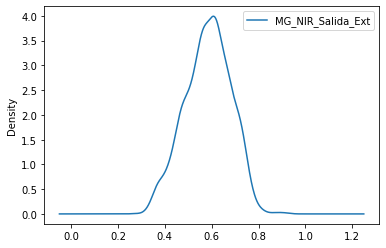

In [12]:
y.plot(kind='kde', backend = 'matplotlib')

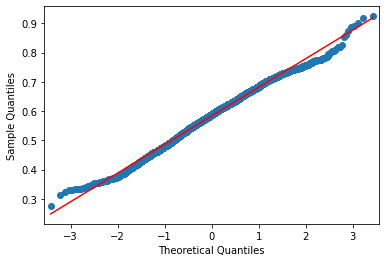

In [13]:
import statsmodels.api as sm
import pylab

sm.qqplot(y.sort_values('MG_NIR_Salida_Ext'), line='s')
pylab.show()

Text(0.5, 1.0, 'Power spectral density ')

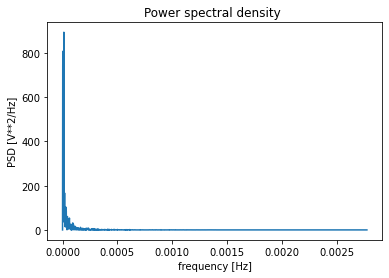

In [28]:
from scipy import signal
G, Pyy_den = signal.periodogram(y['MG_NIR_Salida_Ext'], fs=1/180)
plt.plot(G, Pyy_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Power spectral density ')

In [15]:
print('La frecuencia de la fundamental es: ', G[np.where(Pyy_den == Pyy_den.max())], '[Hz.] que representa un periodo de: ',1/G[7]/60/60,' hs.')

La frecuencia de la fundamental es:  [1.19108389e-05] [Hz.] que representa un periodo de:  23.321428571428573  hs.


<AxesSubplot:xlabel='Time', ylabel='MG_NIR_Salida_Ext'>

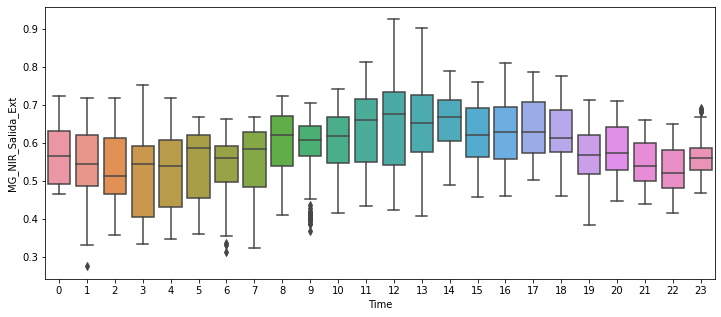

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = y.index.hour, y = y['MG_NIR_Salida_Ext'], ax = ax)

In this analysis we can see that the distribution of the series approximately normal, and contains a few outliers.
In the hourly box plot we can observe a seasonal component of approximately 23 hs of period.

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose

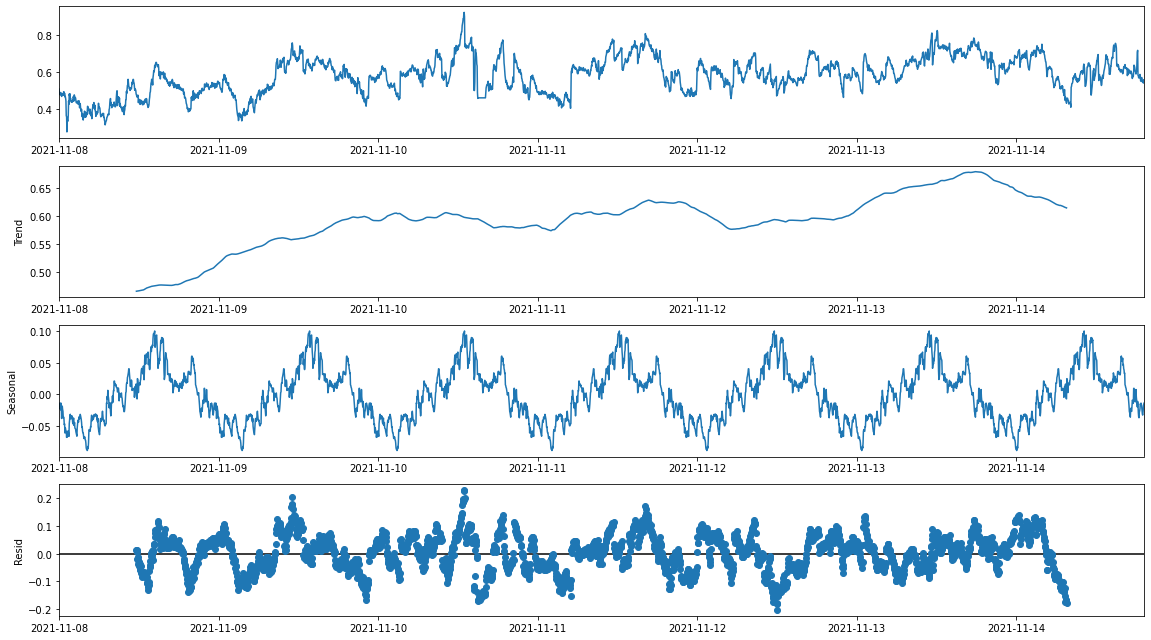

In [71]:
results_ = seasonal_decompose(y, period=466)
fig = results_.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

# ARIMA Model

In [17]:
from statsmodels.tsa.stattools import adfuller
adfuller(y)

(-4.5042631850148656,
 0.00019318132272168076,
 15,
 3249,
 {'1%': -3.4323643041051666,
  '5%': -2.862429999065346,
  '10%': -2.5672437656428793},
 -16657.24865815721)

In [18]:
from statsmodels.tsa.stattools import kpss
kpss(y.dropna())

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




(2.627170360737052,
 0.01,
 36,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [19]:
from statsmodels.tsa.stattools import kpss
kpss(y.diff().dropna())

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




(0.011539242684388825,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

# Dickey-fuller

Based on the Dickey-Fuller's test:

${H}_{0}:$ the series is not stationary.

P-value close to -> 0 Reject null hypothesis -> **The series is stationary to some order of differentiation.**


# KPSS
Based on the KPSS test:

${H}_{0}:$ the series is stationary.

Series without differentiation: p-value close to 0 - > **I reject null hypothesis - > the series is not stationary.**

Series with first order differentiation: p-value = 0.1 > 0.05 -> **I accept null hypothesis -> the series is stationary.**

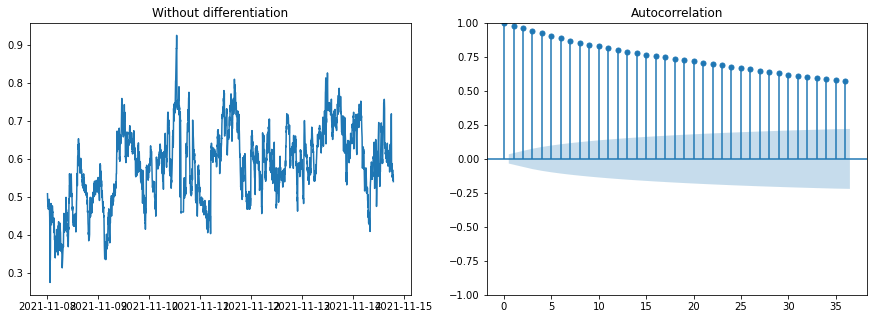

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)
ax1.set_title('Without differentiation')
ax1.plot(y)

ax2 = f.add_subplot(122)
plot_acf(y, ax=ax2)
plt.show()

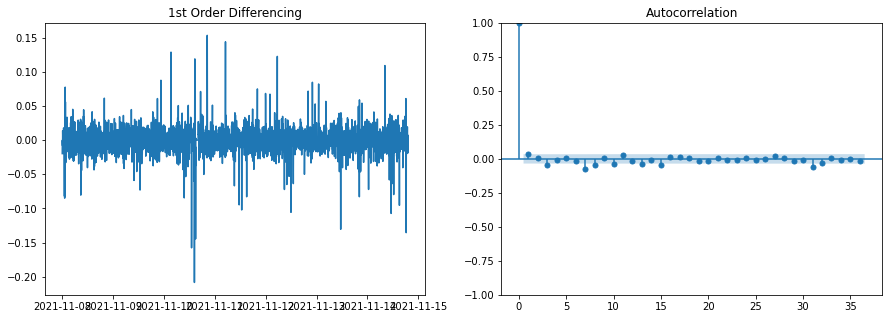

In [21]:
from statsmodels.graphics.tsaplots import plot_acf
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(y.diff())

ax2 = f.add_subplot(122)
plot_acf(y.diff().dropna(), ax=ax2)
plt.show()

In [22]:
print('Dickey-fuller p-value: ',adfuller(y)[1],' without differencing')
print('Dickey-fuller p-value: ',adfuller(y.diff().dropna())[1],' 1st order differencing')

Dickey-fuller p-value:  0.00019318132272168076  without differencing
Dickey-fuller p-value:  4.234485492564482e-30  1st order differencing


c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



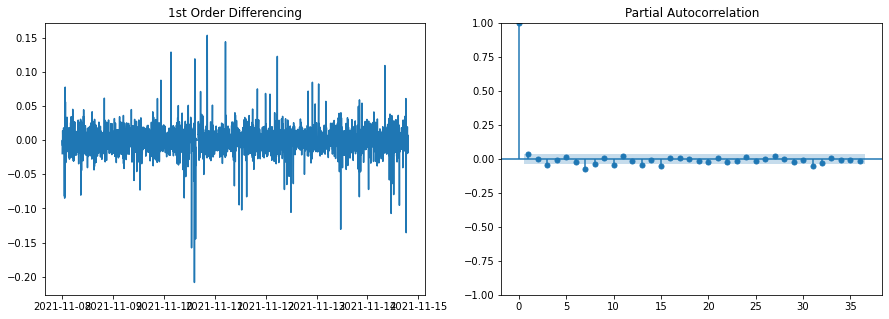

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(y.diff())

ax2 = f.add_subplot(122)
plot_pacf(y.diff().dropna(), ax=ax2)
plt.show()

Due to the p-value of the dickey-fuller's test for the signal without differencing is close to 0, we can assume that the series or the 1st order differentiation are stationary. Since the ACF plot for the original series decay slowly, I use a 1st order differentiation.


Now we see that the ACF decays faster, so we can assume $d=1$.

To choose the $p(AR)$ of the model I saw the lags of major importance in the PACF plot. We can see that the partial auto correlation for the first lag has a value out the umbral, so we can assume $p=1$.

Using the same criteria in the ACF plot, we can estimate the value for the q(MA) parameter. We can choose $q=1$ or $q=0$.

In [24]:
# ARIMA model definition

from statsmodels.tsa.arima.model import ARIMA
ARIMA_order = (1,1,1)

arima_model = ARIMA(y, order = (1, 1, 1))   # (p, d, q)
model = arima_model.fit()
print(model.summary())

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency 3T will be used.

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency 3T will be used.

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency 3T will be used.



                               SARIMAX Results                                
Dep. Variable:      MG_NIR_Salida_Ext   No. Observations:                 3265
Model:                 ARIMA(1, 1, 1)   Log Likelihood                8356.032
Date:                Sat, 11 Jun 2022   AIC                         -16706.064
Time:                        16:30:25   BIC                         -16687.792
Sample:                    11-08-2021   HQIC                        -16699.520
                         - 11-14-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0192      0.440      0.044      0.965      -0.844       0.882
ma.L1          0.0176      0.441      0.040      0.968      -0.846       0.881
sigma2         0.0003   3.23e-06    108.208      0.0

### Forecasting for the next 3 minutes.

In [25]:
# evaluate an ARIMA model using a walk-forward validation

y_train = pd.DataFrame(train_set['MG_NIR_Salida_Ext'], columns = ['MG_NIR_Salida_Ext'])
y_test = pd.DataFrame(test_set['MG_NIR_Salida_Ext'], columns = ['MG_NIR_Salida_Ext'])
history = [x for x in y_train['MG_NIR_Salida_Ext'].values]
predictions = list()
# walk-forward validation
for t in range(len(y_test)):
	model = ARIMA(history, order=(1,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = y_test['MG_NIR_Salida_Ext'][t]
	history.append(obs)

	#print('predicted=%f, expected=%f' % (yhat, obs))
y_test['MG_NIR_Salida_Ext_pred'] = predictions

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\U

In [26]:
y_test.plot()

### Forecasting for the next 30 minutes.

In [27]:
# evaluate an ARIMA model using a walk-forward validation

y_train = pd.DataFrame(train_set['MG_NIR_Salida_Ext'], columns = ['MG_NIR_Salida_Ext'])
y_test = pd.DataFrame(test_set['MG_NIR_Salida_Ext'], columns = ['MG_NIR_Salida_Ext'])
history = [x for x in y_train['MG_NIR_Salida_Ext'].values]
predictions = list()
# walk-forward validation

for t in range(len(y_test)):
	model = ARIMA(history, order = ARIMA_order)
	model_fit = model.fit()
	output = model_fit.forecast(10)
	yhat = output[0]
	predictions.append(output)
	obs = y_test['MG_NIR_Salida_Ext'][t]
	history.append(obs)

	#print('predicted=%f, expected=%f' % (yhat, obs))
y_test['MG_NIR_Salida_Ext_pred'] = predictions

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\alexb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\U

In [28]:
pred_df = pd.DataFrame(predictions)

i=0
for col in pred_df.columns:
    pred_df[col] = pred_df[col].shift(i)
    i+=1
    # print(col)

pred_df['y_real']=y_test['MG_NIR_Salida_Ext'][:len(predictions)].values

In [29]:
pred_df

,0,1,2,3,4,5,6,7,8,9,y_real
0,0.539204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.545433
1,0.545649,0.539191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.542020
2,0.541891,0.545653,0.539191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.526029
3,0.525445,0.541889,0.545653,0.539191,NaN,NaN,NaN,NaN,NaN,NaN,0.530115
4,0.530275,0.525433,0.541889,0.545653,0.539191,NaN,NaN,NaN,NaN,NaN,0.538483
...,...,...,...,...,...,...,...,...,...,...,...
811,0.628773,0.644954,0.647064,0.634223,0.619294,0.629214,0.636167,0.644906,0.644824,0.649423,0.631937
812,0.632021,0.628826,0.644941,0.647058,0.634227,0.619294,0.629214,0.636167,0.644906,0.644824,0.644867
813,0.644970,0.631990,0.628807,0.644946,0.647060,0.634225,0.619294,0.629214,0.636167,0.644906,0.641501
814,0.641428,0.644933,0.632002,0.628814,0.644944,0.647059,0.634226,0.619294,0.629214,0.636167,0.657766


In [30]:
pred_df.plot()

#### CONCLUSION
It can be seen that the model always predicts a value close to the last observed value. For this reason, the proposed ARIMA model is not useful for the application in which it is going to be used.

# LSTM: multivariate analysis

Forecasting of the sample $t+15$ using the samples $[t-60 : t]$

![](2022-06-05-23-27-43.png)

In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.plotting.backend = "plotly"

pd.set_option("display.max_columns", None) # Muestra todas las columnas de los DF

C:\Users\alexb\AppData\Local\Temp\ipykernel_11860\2381816931.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
data  = pd.read_pickle('./TO_FE_20211221.pkl')
# Divido los datos en un 80 % train y 20 % test
train_set = data[:round(len(data)*0.8)]
test_set = data[round(len(data)*0.8):]

In [3]:
data  = pd.read_pickle('./TO_FE_20211221.pkl')
data = data[['MG_NIR_Salida_Ext', 'Humedad_Semilla', 'T_Lam_9', 'Conc_Miscela']]

data['Humedad_Semilla_LAG'] = data['Humedad_Semilla'].shift(periods = 30) # 90 min
data['T_Lam_9_LAG'] = data['T_Lam_9'].shift(periods = 30) # 90 min
data = data['2021-11-09 06:00:00':]

In [6]:
data.plot()

In [7]:
data.shape

(3481, 6)

In [8]:
train_set = data[:'2021-11-16 00:00:00']
test_set = data['2021-11-16 00:00:00':]

In [9]:
X_train = train_set
#y_train = train_set['MG_NIR_Salida_Ext']
X_test = test_set
#y_test = test_set['MG_NIR_Salida_Ext']

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

In [10]:
X_train_scaled.plot()

In [11]:
X_train_scaled = scaler.fit_transform(X_train)

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future =5
n_past = 60  

#Reformat input data into a shape: (n_samples x timesteps x n_features)

for i in range(n_past, len(X_train_scaled) - n_future +1):

    trainX.append(X_train_scaled[i - n_past:i, 0:X_train.shape[1]])
    trainY.append(X_train_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (3177, 60, 6).
trainY shape == (3177, 1).


In [26]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(16, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 16)            1472      
                                                                 
 lstm_7 (LSTM)               (None, 60, 16)            2112      
                                                                 
 dropout_4 (Dropout)         (None, 60, 16)            0         
                                                                 
 lstm_8 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,713
Trainable params: 5,713
Non-traina

Epoch 1/50
6/6 [==============================] - 4s 187ms/step - loss: 1.0729 - val_loss: 0.4115
Epoch 2/50
6/6 [==============================] - 1s 116ms/step - loss: 1.0059 - val_loss: 0.3935
Epoch 3/50
6/6 [==============================] - 1s 105ms/step - loss: 0.9585 - val_loss: 0.3775
Epoch 4/50
6/6 [==============================] - 1s 105ms/step - loss: 0.9101 - val_loss: 0.3621
Epoch 5/50
6/6 [==============================] - 1s 105ms/step - loss: 0.8722 - val_loss: 0.3322
Epoch 6/50
6/6 [==============================] - 1s 117ms/step - loss: 0.8072 - val_loss: 0.3181
Epoch 7/50
6/6 [==============================] - 1s 115ms/step - loss: 0.7284 - val_loss: 0.2829
Epoch 8/50
6/6 [==============================] - 1s 114ms/step - loss: 0.6374 - val_loss: 0.2587
Epoch 9/50
6/6 [==============================] - 1s 108ms/step - loss: 0.5517 - val_loss: 0.2565
Epoch 10/50
6/6 [==============================] - 1s 109ms/step - loss: 0.5232 - val_loss: 0.2554
Epoch 11/50
6/6 [==

Text(0, 0.5, 'Loss')

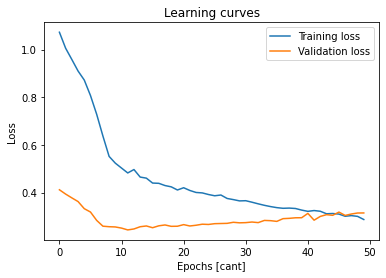

In [27]:
# fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=512, validation_split=0.1, verbose=1)

# plot history
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epochs [cant]')
plt.ylabel('Loss')

In [28]:
# Test set

X_test_scaled = scaler.transform(X_test)
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 

#Empty lists to be populated using formatted training data
testX = []
testY = []

#Reformat input data into a shape: (n_samples x timesteps x n_features)

for i in range(n_past, len(X_test_scaled) - n_future +1):

    testX.append(X_test_scaled[i - n_past:i, 0:X_train.shape[1]])
    testY.append(X_test_scaled[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (177, 60, 6).
testY shape == (177, 1).


In [29]:
#Make prediction
prediction = model.predict(testX) #shape = (n, 1) where n is the n_days_for_prediction

6/6 [==============================] - 0s 8ms/step


In [30]:
# Perform inverse transformation to rescale back to original range
# Since we used 5 variables for transform, the inverse expects same dimensions
# Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, X_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

testY_copies = np.repeat(testY, X_train.shape[1], axis=-1)
testY_inverse_transform = scaler.inverse_transform(testY_copies)[:,0]


In [31]:
forecastDF = pd.DataFrame(y_pred_future, columns = ['Forecast'])
forecastDF['MG_NIR_Salida_Ext'] = testY_inverse_transform

In [32]:
forecastDF.plot()

In [65]:
# Defino métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def get_metrics(y_true, y_pred, model_name):

    RMSE = mean_squared_error(y_true, y_pred, squared=False)
    MAE = mean_absolute_error(y_true, y_pred)
    EVS = explained_variance_score(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    print('El MSE obtenido con ' + model_name + ' es: ' + str(RMSE))
    print('El MAE obtenido con ' + model_name + ' es: ' + str(MAE))
    print('El EVS obtenido con ' + model_name + ' es: ' + str(EVS))
    print('El R2 obtenido con ' + model_name + ' es: ' + str(R2))
    
    return [model_name, RMSE, MAE, EVS, R2]

metrics_DF = pd.DataFrame(columns = ['MODEL NAME', 'RMSE', 'MAE', 'EVS', 'R2'])
metrics_DF.loc[len(metrics_DF)] = get_metrics(testY, prediction, 'LSTM')

El MSE obtenido con LSTM es: 0.8119624721168339
El MAE obtenido con LSTM es: 0.6795461893272343
El EVS obtenido con LSTM es: 0.09383994571872878
El R2 obtenido con LSTM es: -0.1439878986291503
